In [1]:
import sys
import os
sys.path.append(os.path.abspath('../')) # Point to project root

In [7]:
from modules.trainer import train_agent
from modules.utils import *
from env.custom_hopper import *

In [3]:
config = {
    'env_id': 'CustomHopper-source-v0',
    'algo': 'sac',
    'seed': 42,
    'timesteps': 1_000_000,
    'vectorize': False,     # make vectorized env
    'normalize': False,     # normalize observations and rewards
    'lr': 1e-3,             # Learning rate
    
    # Experiment Settings
    'use_udr': True,          # Enable wrapper
    'use_doraemon': True,     # Enable adaptive callback
    'udr_initial_range': (1.0, 1.0) # Start from source (Doraemon will expand this)
}

In [4]:
# ---------------------------------------------------------
# TRAINING
# ---------------------------------------------------------
model, callbacks = train_agent(config)

Using cpu device
Starting training on 1 parallel environments with Normalization...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.8     |
|    ep_rew_mean     | 18.3     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4870     |
|    time_elapsed    | 0        |
|    total_timesteps | 95       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 14.6     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 350      |
|    time_elapsed    | 0        |
|    total_timesteps | 165      |
| train/             |          |
|    actor_loss      | -4.87    |
|    critic_loss     | 0.628    |
|    ent_coef        | 0.939    |
|    ent_coef_loss   | -0.318   |
|    learning_rate   | 0.001    |
|    n_updates       | 64       |
--------------------------------

In [11]:
# Extract the specific callback from the list returned by the trainer
if callbacks and len(callbacks) > 0:
    doraemon_cb = callbacks[0]
else:
    doraemon_cb = None
    print("Warning: No callbacks found!")

No log file found at ./logs//monitor.csv


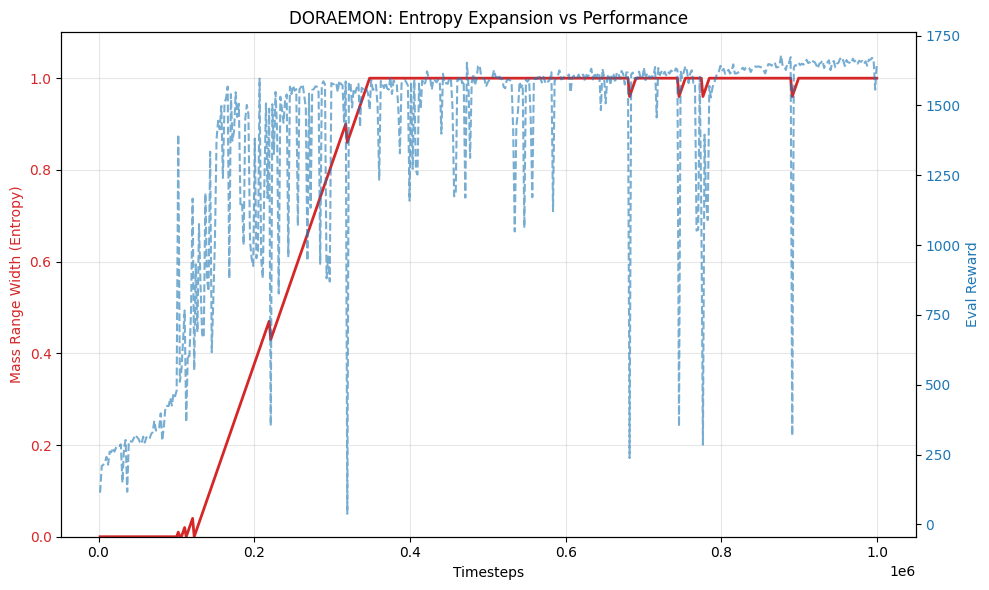

In [12]:
# ---------------------------------------------------------
# VISUALIZATION
# ---------------------------------------------------------

# Plot Learning Curve (General Training)
plot_learning_curve("./logs/", title="SAC Training with Doraemon")

# Plot Doraemon Dynamics (The "Money Shot")
if doraemon_cb:
    plot_doraemon_dynamics(doraemon_cb)
    # Interpretation: You should see the Red Line (Width) growing
    # whenever the Blue Dashed Line (Reward) is high.

In [14]:
# ---------------------------------------------------------
# SIM2REAL EVALUATION
# ---------------------------------------------------------
# Define Source and Target environments for final test
# Note: Target usually a has fixed, shifted mass: Torso +1kg
source_env = gym.make('CustomHopper-source-v0')
target_env = gym.make('CustomHopper-target-v0')

evaluate_sim2real(model, source_env, target_env)

--- Evaluating over 20 episodes ---


/Users/alessandrobenvenuti/miniconda3/envs/RL_lab04/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Source Env Reward: 1675.38 +/- 23.68
Target Env Reward: 991.33 +/- 79.00
Sim2Real Gap: 684.05


(np.float64(1675.3794836342336), np.float64(991.3340040624141))